In [39]:
import numpy as np
from numpy.linalg import inv
import pandas as pd 
import matplotlib.pyplot as plt

import time

from sklearn.datasets import fetch_california_housing

import statsmodels.api as sm

from utils import linear_press, linear_loocv, ridge_press, ridge_loocv, all_same

In [15]:
housing = fetch_california_housing()
X = sm.add_constant(pd.DataFrame(housing.data, columns=housing.feature_names))
y = housing.target

In [16]:
model = sm.OLS(y, X).fit()

In [17]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        13:56:12   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.9419      0.659    -56.067      0.0

# LOOCV for linear regression

In [25]:
%%time
def linear_press(X, y):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n, p = X.shape
    I = np.identity(n)
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    rss = y.T @ (I - H) @ np.diag(np.diag(I - H) ** (-2)) @ (I - H) @ y 
    return rss.item()

press_linear = linear_press(X, y)

CPU times: user 6.8 s, sys: 15.2 s, total: 22 s
Wall time: 11.3 s


In [27]:
%%time
def linear_loocv(X, y):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n, p = X.shape
    eps = []
    for i in range(n):
        X_i, y_i = X[np.arange(X.shape[0]) != i], y[np.arange(y.shape[0]) != i]
        beta_i = inv(X_i.T @ X_i) @ X_i.T @ y_i     
        eps.append( y[i] - X[i] @ beta_i ) 
    return np.sum(np.array(eps) ** 2)

press_linear_loocv = linear_loocv(X, y)

CPU times: user 3min 33s, sys: 8.84 s, total: 3min 42s
Wall time: 32 s


In [30]:
abs(press_linear -  press_linear_loocv) < 1e-5

True

## Ridge regression

In [37]:
def ridge_press(X, y, alpha):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n, p = X.shape
    I = np.identity(n)
    H = X @ inv(X.T @ X + alpha * np.identity(p)) @ X.T 
    rss = y.T @ (I - H) @ np.diag(np.diag(I - H) ** (-2)) @ (I - H) @ y 
    return rss.item()


def ridge_loocv(X, y, alpha):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n, p = X.shape
    eps = []
    for i in range(n):
        X_i, y_i = X[np.arange(X.shape[0]) != i], y[np.arange(y.shape[0]) != i]
        beta_i = inv(X_i.T @ X_i + alpha * np.identity(p)) @ X_i.T @ y_i     
        eps.append( y[i] - X[i] @ beta_i ) 
    return np.sum(np.array(eps) ** 2)

In [31]:
alphas = [10**(i-3) for i in range(7)]

In [38]:
press_ridge, press_ridge_loocv = [], []

for alpha in alphas:
    press_ridge.append(ridge_press(X, y, alpha))
    press_ridge_loocv.append(ridge_loocv(X, y, alpha))

all_same(press_ridge, press_ridge_loocv)

True

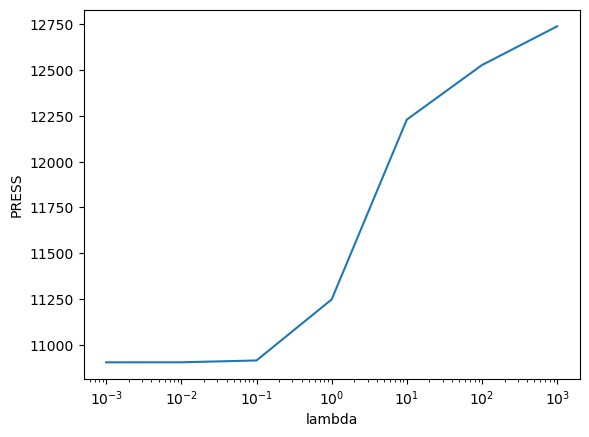

In [49]:
plt.plot(alphas, press_ridge)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("PRESS")
# plt.title("PRESS statistic at different lambda")
plt.show()